In [1]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import math
from matplotlib import rc
import sys
from PIL import Image
import random
import pandas as pd
from collections import deque

np.set_printoptions(threshold=sys.maxsize)

<IPython.core.display.Javascript object>

This code runs with mesa version 3.00 or higher

In [2]:
# check mesa version
print("Mesa version: ", mesa.__version__)

Mesa version:  3.0.3


## Create floor plan for simulation

In [3]:
def image_to_floor_plan(image_path, threshold=128):
    # Load the image
    img = Image.open(image_path)
    
    # Convert to grayscale
    grayscale_img = img.convert("L")  # "L" mode is 8-bit grayscale

    # Convert to numpy array
    img_array = np.array(grayscale_img)
    
    # Binarize the image based on the threshold
    floor_plan = (img_array < threshold).astype(int)  # 1 for obstacles, 0 for walkable
    
    return floor_plan

In [4]:
floor_plan_dir = "./assets/aula_plattegrond_1stage.png"
floor_plan = image_to_floor_plan(floor_plan_dir)

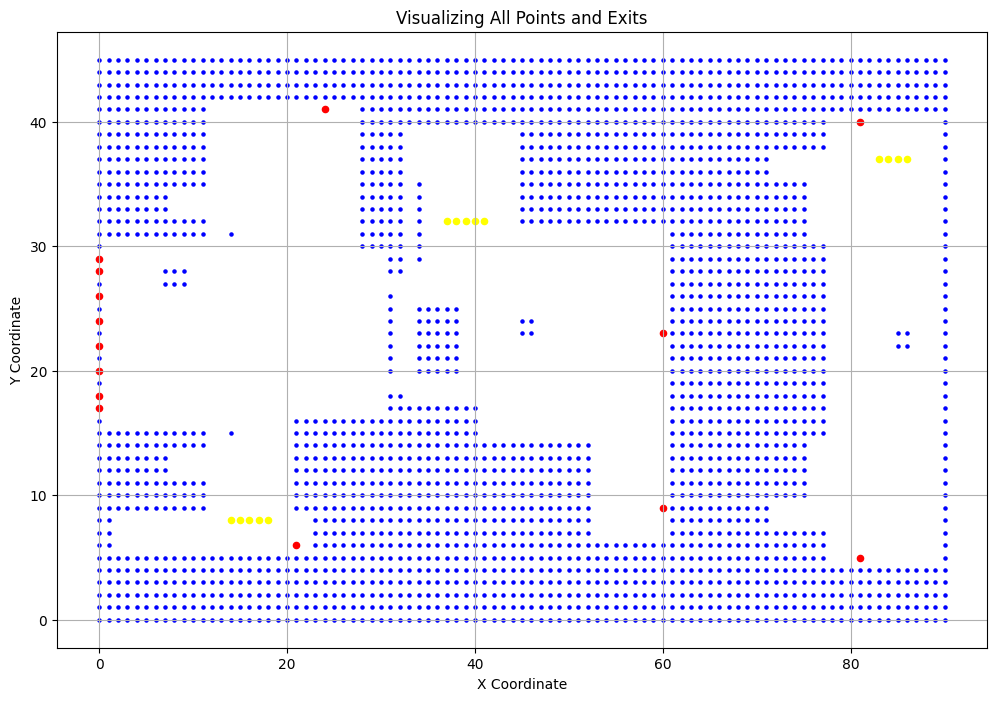

In [5]:
# Prepare data for scatter plot
rows, cols = np.where(floor_plan == 1)
max_y = floor_plan.shape[0] - 1  # For inverting the y-axis
adjusted_rows = [max_y - y for y in rows]

# Extract coordinates for the entire grid
coordinates = list(zip(cols, adjusted_rows))
x_coords = [coord[0] for coord in coordinates]
y_coords = [coord[1] for coord in coordinates]

# Determine exits
exit_locations = [[0, 29], [0, 28,], [0, 26], [0,24], [0,22], [0,20], [0, 18], [0, 17], [24, 41], [21, 6], [60, 23], [60, 9], [81, 40], [81, 5]]

exit_x = [coord[0] for coord in exit_locations]
exit_y = [coord[1] for coord in exit_locations]

# Determine bars
bar_locations = [[x, 8] for x in range(14, 19)] + [[x, 32] for x in range(37, 42)] + [[x, 37] for x in range(83, 87)]

bar_x = [coord[0] for coord in bar_locations]
bar_y = [coord[1] for coord in bar_locations]

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords, c='blue', s=5, label='Points')  # All points in blue
plt.scatter(exit_x, exit_y, c='red', s=20, label='Exits')  # Exits in red
plt.scatter(bar_x, bar_y, c='yellow', s=20, label='Bars')
plt.title("Visualizing All Points and Exits")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

# Base Model

In [24]:
###################
### AGENT CLASS ###
###################
# Function to calculate Euclidean distance (distance between two points)
def euclidean_distance(pos1, pos2):
    # Use the formula to calculate distance between two coordinates
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

# Define the NavigationAgent class
class NavigationAgent(Agent):
    def __init__(self, model, vision): # Default vision range of 5 cells
        super().__init__(model)  # MESA `Agent` class initialization, auto-assigns unique_id in Mesa 3.0
        
        # Attributes of each agent 
        #TODO: eigenlijk moeten de eerste twee bij Visitor omdat alleen Visitor deze gebruikt
        self.found_exit = False  # Track if agent has reached the exit
        self.previous_pos = None  # Previous position of the agent
        self.vision = vision  # Vision range of the agent
        self.vision_area = None
        
    def check_visibility(self, items_to_check):
        """
        Checks which cells (or agents) are visible.
        - If items_to_check is a list of (x, y) tuples, returns a list of (x, y) that are visible.
        - If items_to_check is a list of agent objects, returns a list of agents whose .pos is visible.
        """
        
        # Return if items_to_check is empty
        if not items_to_check:
            return
        
        # Agent's current position
        agent_x, agent_y = self.pos
        
        visible_cells = []  # List to store cells that are visible to the agent

        # Check visibility for each cell in the neighborhood
        for target_x, target_y in self.vision_area:
            # Bresenham's Line Algorithm for line-of-sight
            delta_x = abs(target_x - agent_x)
            delta_y = abs(target_y - agent_y)
            step_x = 1 if agent_x < target_x else -1
            step_y = 1 if agent_y < target_y else -1
            error = delta_x - delta_y

            # Start tracing the line from the agent's position
            current_x, current_y = agent_x, agent_y
            is_visible = True  # Assume the cell is visible until proven otherwise

            while (current_x, current_y) != (target_x, target_y):
                if isinstance(self, Crew):
                    # If an obstacle is in the way, mark the cell as not visible
                    if (current_x, current_y) in self.model.obstacle_set_crew:
                        is_visible = False
                        break
                else:
                    if (current_x, current_y) in self.model.obstacle_set:
                        is_visible = False
                        break

                # Adjust the error term and move to the next cell along the line
                double_error = 2 * error
                if double_error > -delta_y:
                    error -= delta_y
                    current_x += step_x
                if double_error < delta_x:
                    error += delta_x
                    current_y += step_y

            # If the cell is visible, add it to the visible_cells list
            if is_visible:
                visible_cells.append((target_x, target_y))
                
        # Convert to set for efficiency
        visible_cells_set = set(visible_cells)
        
        # Safely retrieve the first item without assuming list-like indexing
        first_item = next(iter(items_to_check), None)
        if first_item is None:
            return []
        
        # Detect whether the input is cells (tuples) or agents (with a .pos attribute)
        input_is_agents = hasattr(first_item, "pos")
        
        # Build return value depending on input type
        if input_is_agents:
            # If the input was agents, return a dict { (x,y): agent } for those whose positions are in visible_cells_set
            agents_to_check = items_to_check
            intersection_dict = {
                agent.pos: agent
                for agent in agents_to_check
                if agent.pos in visible_cells_set
            }
            return intersection_dict
        else:
            # If the input was cell coordinates, return a list of the (x, y) that are visible
            coords_to_check = items_to_check
            intersection = visible_cells_set.intersection(coords_to_check)
            return list(intersection)

    def step(self):    
        self.vision_area = self.model.grid.get_neighborhood(self.pos, moore=True, radius=self.vision, include_center=False)
            
class Visitor(NavigationAgent):
    def __init__(self, model, vision, drinks=0, friends=[]):
        super().__init__(model, vision=vision)
        
        # Attributes for the Visitor subclass
        # TODO: hier iets aanpassen, soms geen van beide
        self.social = random.choices([True, False], weights=[0.6, 0.4])[0]
        self.observer = random.choices([True, False], weights=[0.7, 0.3])[0]
        
        self.drinks = drinks
        self.friends = friends
        self.my_group = None
        self.seen_crew = False
        
        self.toilet_timer = random.randrange(1, 2700)
        self.toilet_delay = random.randrange(30, 300)
        self.bar_timer = random.randrange(1, 1800)
        self.bar_delay = random.randrange(60, 300)
        self.previous_location = None # Remember where you were before a timer went off 
        self.state = None
        self.target_location = None
        
        # TODO : ONDERSTAANDE DINGEN ZIJN TOEGEVOEGD (NOT SURE ABOUT CHOSEN FRIEND)
        self.chosen_friend = None    
        
        self.search_timer = random.randrange(5, 20)
        self.stair_target = None
        
        self.current_floor = None
        self.target_floor = None
    
    # TODO: New pathfinding algorithm    
    def move_towards_target(self, target_location):
        """
        Input is a coordinate tuple of the target. Function checks whether the target is on another floor and updates the target to the stairs if that is the case. Then moves to the target.
        """
        self.previous_pos = self.pos  # Store the current position before moving
        
        neighbourhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1, include_center=False)
        
        min_distance = float('inf')  # Start with a very large distance
        best_step = None  # Initialize best step as None
        
        # Check whether agent's target is on a different floor
        self.check_stairs()
        
        # If the agent's target is on a different floor, change the current target to closest stair
        if self.stair_target:
            target = self.stair_target
        else:
            target = target_location
        
        if target in self.model.target_cells:    
            # Retrieve the distance map for the target_location
            distance_map = self.model.distance_maps.get(target)
            current_distance = distance_map.get(self.pos, None)
            
            valid_steps = [step for step in neighbourhood if step not in self.model.obstacle_set and len(self.model.grid.get_cell_list_contents(step)) < self.model.cell_capacity]
            
            # Filter steps that are closer to the target
            closer_steps = [step for step in valid_steps if distance_map.get(step, float('inf')) < current_distance]
    
            if closer_steps:
                # Choose the step with the smallest distance value
                best_step = min(
                    closer_steps,
                    key=lambda step: distance_map.get(step, float('inf'))
                )
                self.model.grid.move_agent(self, best_step)
            else:
                # If no closer steps are found, fallback to random movement
                #print('No better step found, here is info. Target: ', target, '. Position: ', self.pos, '. Distance map: ', distance_map, '. Valid steps: ', valid_steps, '. Current distance: ', current_distance)
                self.move_randomly()
        else:
            # Check each possible step to find the one closest to the target
            for step in neighbourhood:
                # Only consider steps that don't have obstacles and have less agents than cell capacity
                if step not in self.model.obstacle_set and len(self.model.grid.get_cell_list_contents(step)) < self.model.cell_capacity:
                    dist = euclidean_distance(step, target)  # Distance to the target
                    if dist < min_distance:
                        min_distance = dist
                        best_step = step  # Update best step to be closer to the exit
            if best_step:
                # MESA `move_agent` function moves the agent to the new cell
                self.model.grid.move_agent(self, best_step)            
        
    def take_stairs(self):
        # Define stair connections as a dictionary
        stair_connections = {"north_GF": self.model.stairs_north_GF,
                            "north_FF": self.model.stairs_north_FF,
                            "south_GF": self.model.stairs_south_GF,
                            "south_FF": self.model.stairs_south_FF}

        # Iterate through the stair connections to find the current position
        for current_stairs, target_stairs in [("north_GF", "north_FF"),("north_FF", "north_GF"),
            ("south_GF", "south_FF"), ("south_FF", "south_GF")]:
            if self.pos in stair_connections[current_stairs]:
                self.model.grid.move_agent(self, random.choice(stair_connections[target_stairs]))
                self.stair_target = None
                break  # Exit the loop once a match is found
                
    def check_stairs(self):
        """
        Checks if agent is on a different floor than their target and needs to take the stairs.
        Returns nothing but selects the closest stair as the next target (i.e. self.stair_target to nearest stair). 
        """        
        #print('First floor coord is: ', first_floor_coord)
        target_floor = ['First' if self.target_location in self.model.first_floor_coordinates else 'ground']
        #print('Target floor is: ', target_floor, '. While target location is: ', self.target_location)
        current_floor = ['First' if self.pos in self.model.first_floor_coordinates else 'ground']
        
        self.target_floor = target_floor
        self.current_floor = current_floor

        if target_floor != current_floor:
            self.set_closest_target(self.model.all_stairs)
    
    def set_closest_target(self, coordinates):
        """
        Takes either a set of list of coordinates and determines which of the input coordinates is closest to the agent. Then sets that as target.
        """
        min_distance = float('inf')  # Start with a very large distance
        closest_point = None  # Initialize best step as None
        
        # Check each possible step to find the one closest to the exit
        for point in coordinates:
            dist = euclidean_distance(self.pos, point)
            if dist < min_distance:
                min_distance = dist
                closest_point = point
        
        # Check if function is being used to take the stairs
        if closest_point in self.model.all_stairs:
            self.stair_target = closest_point
        else:
            self.target_location = closest_point
            
    # Function to move the agent randomly if the exit is not in sight
    def move_randomly(self):
        self.previous_pos = self.pos
        self.target_location = None
        
        # Filter steps to only those without obstacles and with fewer than cell capacity agents
        valid_steps = [step for step in self.model.grid.get_neighborhood(self.pos, moore=True, radius=1, include_center=False) if step not in self.model.obstacle_set and len(self.model.grid.get_cell_list_contents(step)) < self.model.cell_capacity]
        
        if valid_steps:
            # Randomly choose a valid position and move there
            random_step = self.random.choice(valid_steps)
            # MESA `move_agent` function moves the agent to the chosen position
            self.model.grid.move_agent(self, random_step)
    
    def find_friends(self):
        # Get all agents in vision
        agents_in_vision = [agent for agent in self.model.grid.get_cell_list_contents(self.vision_area)]
        
        if agents_in_vision:
            friends_in_vision_far = list(set(agents_in_vision) & set(self.friends))
        else:
            friends_in_vision_far = []
        
        # TODO: Deze afstand heb ik dus gefreestyled, die moet eienlijk ook een input van het model worden
        nodes_in_vision_close = self.model.grid.get_neighborhood(self.pos, moore=True, radius=(int(self.vision/2)), include_center=False)
        agents_in_vision_close = [agent for agent in self.model.grid.get_cell_list_contents(nodes_in_vision_close)]

        if agents_in_vision_close:
            friends_in_vision_close = list(set(agents_in_vision_close) & set(self.friends))
        else:
            friends_in_vision_close = []

        # Keep only the friends that are in vision, but are far away
        ring = list(set(friends_in_vision_far) ^ set(friends_in_vision_close))

        if friends_in_vision_close:
            self.state = "Friends close by - moving randomly"
            self.move_randomly()
        elif ring:
            visible_friends = self.check_visibility(ring) 
            if visible_friends:
                coord, chosen_friend = random.choice(list(visible_friends.items())) #kan nu natuurlijk wel halverwege switchen van vriend maar dat is dan maar even zo
                self.chosen_friend = chosen_friend
                if chosen_friend.toilet_timer != 0 and chosen_friend.bar_timer != 0:
                    self.move_towards_target(coord)
                    self.state = "Friends far away - moving closer"
                else:
                    self.state = "Friends far away - timer went off - moving randomly"
                    self.move_randomly()
            else:
                self.state = "Friends far away - not visible" 
                self.move_randomly()
        else:
            self.state = "No friends in vision - moving randomly"
            self.move_randomly()

    def normal_behaviour(self):
        # Normal behaviour
        if (self.toilet_timer == 0) and (self.toilet_delay > 0) and (self.pos not in self.model.toilet_coordinates):
            self.state = "Moving towards toilet"
            if self.target_location and (self.pos != self.target_location):
                self.move_towards_target(self.target_location)
            else:
                self.set_closest_target(self.model.toilet_coordinates)
        elif (self.toilet_timer == 0) and (self.toilet_delay > 0) and (self.pos == self.target_location):
            self.toilet_delay -= 1
            self.state = "Waiting at toilet"
        elif (self.toilet_timer == 0) and (self.toilet_delay == 0):
            self.target_location = self.previous_location
            self.move_towards_target(self.target_location)
            self.state = "Moving towards previous location"
            if self.pos == self.target_location:
                    self.state = "Arrived at previous location"
                    self.toilet_timer = random.randrange(2, 20) # same issue 
                    self.toilet_delay = random.randrange(2, 10)
                        
        elif (self.bar_timer <= 0) and (self.bar_delay > 0) and (self.pos not in self.model.bar_coordinates):
            self.state = "Moving towards bar"
            if (self.target_location) and (self.pos != self.target_location):
                self.move_towards_target(self.target_location)
            else:
                self.set_closest_target(self.model.bar_coordinates)
        elif (self.bar_timer <= 0) and (self.bar_delay > 0) and (self.pos == self.target_location):
            self.bar_delay -= 1
            self.state = "Waiting at bar"
        elif (self.bar_timer <= 0) and (self.bar_delay == 0):
            self.target_location = self.previous_location
            self.move_towards_target(self.target_location)
            self.state = "Moving towards previous location"
            if self.pos == self.target_location:
                    self.state = "Arrived at previous location"
                    self.bar_timer = random.randrange(2, 20) # same issue 
                    self.bar_delay = random.randrange(2, 10)
            
        # TODO: timer kunnen nu negatief worden op het moment dat een agent nog bezig is met een andere task --> freeze de timers -> bar timer wordt elke keer negatief, no clue whyyy
        else:
            self.find_friends()
            if self.toilet_timer > 0:
                self.bar_timer -= 1

            if self.bar_timer > 0:
                self.toilet_timer -= 1
           
            self.previous_location = self.pos
            
    def evacuation_behaviour_social(self):
        agents_in_range = [agent for agent in self.model.grid.get_cell_list_contents(self.vision_area)] 
        
        agents_in_vision = self.check_visibility(agents_in_range)
        if agents_in_vision:
            friends_in_vision = {coord: agent for coord, agent in agents_in_vision.items() if agent in self.friends}
        else:
            friends_in_vision = False
        
        main_entrance_point = random.choice(self.model.main_exit) # Pick one of the coordinates from the entrance 
        
        # If you are an observer, you try to find your friend and then find optimal exits
        if self.observer:
            if (self.search_timer > 0) and (self.target_location == None): # TODO: check of dit goed gaat met eventuele oude target location
                if friends_in_vision:
                    coord, friend = random.choice(list(friends_in_vision.items()))
                    if friend.target_location != None:
                        self.target_location = friend.target_location
                        self.move_towards_target(self.target_location)
                        self.state = 'Friend found with target location - stolen target'
                    else:
                        self.search_for_exits()
                        self.state = 'Friend found with NO target location - observing exits' # Override state statements observe exits 
                else:
                    self.move_randomly()
                    self.state = 'No friends in vision - moving randomly till timer or see friends' # Override state statements observe exits
                self.search_timer -= 1
                
            elif (self.search_timer <= 0) and (self.target_location == None):
                self.search_for_exits()
            
            else:
                self.move_towards_target(self.target_location)
        
        # If you are not an observer you opt for going to familiar exits if you can't find your friends        
        else: 
            if (self.search_timer > 0) and (self.target_location == None): # TODO: check of dit goed gaat met eventuele oude target location
                if friends_in_vision:
                    coord, friend = random.choice(list(friends_in_vision.items()))
                    if friend.target_location != None:
                        self.target_location = friend.target_location
                        self.move_towards_target(self.target_location)
                        self.state = 'Friend found with target location - stolen target'
                    else:
                        self.target_location = main_entrance_point
                        self.move_towards_target(self.target_location)
                        self.state = 'Friend found with NO target location - go to main exit' # Override state statements observe exits 
                else:
                    self.move_randomly()
                    self.state = 'No friends in vision - moving randomly till timer' # Override state statements observe exits
                self.search_timer -= 1
                
            elif (self.search_timer <= 0) and (self.target_location == None):
                self.target_location = main_entrance_point
                self.move_towards_target(self.target_location)
                self.state = 'Friend found with NO target location - go to main exit' # Override state statements observe exits 
            
            else:
                self.move_towards_target(self.target_location)
    
    def evacuation_behaviour_independent(self):
        main_entrance_point = random.choice(self.model.main_exit) # Pick one of the coordinates from the entrance 
        
        if self.observer:
            self.search_for_exits()

        else:
            # Go to familiar exit (main entrance), evacuate myself
            self.target_location = main_entrance_point
            self.move_towards_target(self.target_location)
            self.state = "IDGAF - moving towards main entrance"
    
       
    def search_for_exits(self):
        # Check for exits in unobstructed vision
        visible_exits = self.model.exit_locations_set & set(self.vision_area)
        visible_exits = self.check_visibility(visible_exits)

        if visible_exits:
            # Choose the closest exit based on distance map
            closest_exit = min(visible_exits, key=lambda exit_cell: self.model.distance_maps[exit_cell].get(self.pos, float('inf')))
            self.target_location = closest_exit
            # target_exit = random.choice(visible_exits)
            # self.target_location = target_exit
            self.move_towards_target(self.target_location)
            self.state = 'Found close exit - moving towards'

        else:
            self.move_randomly() 
            self.state = "Hasn't found close exit - moving randomly"
            
    def step(self):
        super().step()
        
        # TODO: nog iets van een timer inbouwen voor de initialisatie voordat het alarm afgaat => hier ook iets doen van, als het alarm af gaat, reset alle states en target locations van de agents
        self.take_stairs()
        if self.model.alarm == False:
            self.normal_behaviour()  
        else: 
            # Exit simulation if exit is reached
            if self.pos in self.model.exit_locations_set:
                self.found_exit = True  # Set the agent's exit status to True
                self.model.grid.remove_agent(self)  # MESA function to remove the agent from the grid
                self.remove()  #self.remove() to remove from AgentSet
                self.model.cumulative_exited += 1  # Count this agent in cumulative exited agents
                return
            elif not self.seen_crew:
                if self.social:
                    self.evacuation_behaviour_social()
                else:
                    self.evacuation_behaviour_independent()
            else:
                self.set_closest_target(self.model.exit_locations_set)
                self.move_towards_target(self.target_location)
                self.state = "Seen crew - moving towards nearest exit"
                
class Crew(NavigationAgent):
    def __init__(self, model, vision=50):
        super().__init__(model, vision=vision)

    def broadcast_exits(self):
        agents_in_range = [agent for agent in self.model.grid.get_cell_list_contents(self.vision_area)] 
        agents_in_vision = self.check_visibility(agents_in_range)
        
        if agents_in_vision:
            for agent in agents_in_vision.values():
                agent.seen_crew = True        
            
    def step(self):
        super().step()
        if self.model.alarm:
            self.broadcast_exits()

In [25]:
###################
### MODEL CLASS ###
###################

# Define the model class to handle the overall environment
class FloorPlanModel(Model):
    def __init__(self, number_stages, num_visitors, num_crew, visitor_vision, crew_vision,
                 cell_capacity, max_group_size, alarm_timer):
        super().__init__()  # `Model` class initialization
        
        # Determines the floor plan layout based on the number of stages
        self.number_stages = number_stages
        if self.number_stages == 1:
            floor_plan_path = "./assets/aula_plattegrond_1stage.png"
        elif self.number_stages == 2:
            floor_plan_path = "./assets/aula_plattegrond_2stage.png"
        else:
            raise ValueError(f"Unsupported number_stages: {number_stages}")
        
        # Model breaks if there are too many agents
        if num_visitors > 1500:
            raise ValueError(f"Too many agents, please stay under 1.500 agents.")   
        
        # Set basic model parameters
        self.cell_capacity = cell_capacity
        self.max_group_size = max_group_size
        self.floor_plan = image_to_floor_plan(floor_plan_path)
        self.num_visitors = num_visitors
        self.num_crew = num_crew
        self.visitor_vision = visitor_vision
        self.crew_vision = crew_vision
        self.grid = MultiGrid(floor_plan.shape[1], floor_plan.shape[0], False)  # MESA grid with dimensions; False means no wrapping
        self.alarm = False
        self.alarm_timer = alarm_timer
        self.timestep = 0
        self.cumulative_exited = 0
        
        # Define exit locations manually
        self.main_exit = [(0, 29), (0, 28), (0, 26), (0,24), (0,22), (0,20), (0, 18), (0, 17)]
        self.south_west_exit = [(21, 6)]
        self.north_west_exit = [(24, 41)]
        self.east_exit = [(81, 40)]
        self.south_east_exit = [(81, 5)]
        self.first_south_exit = [(60, 9)]
        self.first_north_exit = [(60, 23)]
        
        # Combine all exit locations for easy checking
        self.exit_locations = (
            self.main_exit + 
            self.south_west_exit + 
            self.north_west_exit + 
            self.east_exit + 
            self.south_east_exit + 
            self.first_south_exit + 
            self.first_north_exit
        )
        
        self.exit_locations_set = set(self.exit_locations) # Turn into set for efficient look-up    
        
        # Define stairs for switching floors
        self.stairs_north_GF = [(8, 34), (8, 33)]
        self.stairs_south_GF = [(8, 13), (8,12)]
        self.stairs_south_FF = [(72, 8), (72, 9)]
        self.stairs_north_FF = [(72, 36), (72, 37)]
        self.all_stairs = self.stairs_north_GF + self.stairs_north_FF + self.stairs_south_GF + self.stairs_south_FF
        self.all_stairs_set = set(self.all_stairs)
        
        # Predefined coordinate ranges for each area where agents can be placed for routing
        self.area_coords = {
            "first_floor": {
                "random": {"x_range": (72, 89), "y_range": (5, 40)},
                "stage":  {"x_range": (79, 88), "y_range": (12, 27)},
                "bar":    {"x_range": (83, 87), "y_range": (32, 36)}
            },
            "ground_floor": {
                "random": {"x_range": (0, 60), "y_range": (6, 41)},
                "stage1": {"x_range": (40, 55), "y_range": (15, 27)},
                "stage2": {"x_range": (12, 22), "y_range": (30, 40)},
                "bar1":   {"x_range": (14, 19), "y_range": (9, 13)},
                "bar2":   {"x_range": (37, 42), "y_range": (28, 31)},
                "toilet": {"x_range": (2, 4), "y_range": (6, 9)}
            }
        }
        
        self.first_floor_coordinates = set(self.convert_dict_to_coordinates('first_floor', 'random'))
        self.bar_coordinates = set(self.convert_dict_to_coordinates('first_floor', 'bar') + self.convert_dict_to_coordinates('ground_floor', 'bar1') + self.convert_dict_to_coordinates('ground_floor', 'bar2'))
        self.toilet_coordinates = set(self.convert_dict_to_coordinates('ground_floor', 'toilet'))
        
        
        # Define obstacles, signs and stairs in the grid
        # y-axis needs to be inverted to get the right visualisation
        rows, cols = np.where(self.floor_plan == 1)        
        max_y = max(rows) 
        adjusted_rows = [max_y - y for y in rows]
        self.obstacles = list(zip(cols, adjusted_rows))
        self.obstacle_set = set(self.obstacles) # Increase efficiency by using a set instead of list
        
        # Define the cells where bars and stages are for crew_vision
        bar_stage_cells = {
            (16, 39), (17, 39), (16, 38), (17, 38), # stage 2 GF
            (45, 24), (46, 24), (45, 23), (46, 23),  # stage 1 GF
            (85, 23), (86, 23), (85, 22), (86, 22),   # stage FF
            (83, 37), (84, 37), (85, 37), (86, 37), # bar 1 FF        
            (38, 32), (39, 32), (40, 32), (41, 32), # bar 2 GF
            (14, 8), (15, 8), (16, 8), (17, 8) # bar 1 GF
        }
        
        # Crew obstacles are different because their vision is based on sound, not eyesight
        # Noise can travel through stages and bars, but you can't see through them
        self.obstacle_set_crew = self.obstacle_set.copy()
        self.obstacle_set_crew -= bar_stage_cells
        
        # Initialize DataCollector (MESA tool for tracking metrics across steps)
        self.datacollector = DataCollector(
            model_reporters={
                "Active Agents": lambda m: len(m.agents),  # Count of agents still active
                "Exited Agents": lambda m: sum(1 for agent in m.agents if isinstance(agent, Visitor) and agent.found_exit),
                "Cumulative Exited Agents": lambda m: m.cumulative_exited,  # Cumulative exited count
                
                # Agents in each of the defined exits:
                "Agents per Cell - Main Exit": lambda m: m.calculate_cell_density(m.main_exit),
                "Agents per Cell - South West Exit": lambda m: m.calculate_cell_density(m.south_west_exit),
                "Agents per Cell - North West Exit": lambda m: m.calculate_cell_density(m.north_west_exit),
                "Agents per Cell - East Exit": lambda m: m.calculate_cell_density(m.east_exit),
                "Agents per Cell - South East Exit": lambda m: m.calculate_cell_density(m.south_east_exit),
                "Agents per Cell - First South Exit": lambda m: m.calculate_cell_density(m.first_south_exit),
                "Agents per Cell - First North Exit": lambda m: m.calculate_cell_density(m.first_north_exit),
                "Agents per Cell - Stairs North": lambda m: m.calculate_cell_density(m.stairs_north_GF),
                "Agents per Cell - Stairs South": lambda m: m.calculate_cell_density(m.stairs_south_GF),
                
                "Agents per Cell - North Stairs": lambda m: m.calculate_cell_density(m.stairs_north_GF + m.stairs_north_FF),
                "Agents per Cell - South Stairs": lambda m: m.calculate_cell_density(m.stairs_south_GF + m.stairs_south_FF)
            },
            agent_reporters={
                "Found Exit": lambda a: a.found_exit if isinstance(a, Visitor) else None,  # Reports exit status per agent
                "Group number": lambda a: a.my_group if isinstance(a, Visitor) else None,
                "Number of friends": lambda a: len(a.friends) if isinstance(a, Visitor) else None,
                "Friends": lambda a: a.friends if isinstance(a, Visitor) else None, # Add the friends
                "State" : lambda a: a.state if isinstance(a, Visitor) else None,
                "Social" : lambda a: a.social if isinstance(a, Visitor) else None,
                "Observer" : lambda a: a.observer if isinstance(a, Visitor) else None,
                "Target Location": lambda a: a.target_location if isinstance(a, Visitor) else None,
                "Current Location": lambda a: a.pos if isinstance(a, Visitor) else None
            }
        )
        
        # Create distance map for pathfinding
        self.distance_maps = {}
    
        rows, cols = np.where(self.floor_plan != 1)        
        max_y = max(rows) 
        adjusted_rows = [max_y - y for y in rows]
        cells = list(zip(cols, adjusted_rows))
        
        self.target_cells = self.all_stairs + self.exit_locations + cells + list(self.bar_coordinates) + list(self.toilet_coordinates)
  
        for cell in self.target_cells:
            dist_map = self.build_distance_map(cell)
            self.distance_maps[cell] = dist_map

        # Placing functions for agents and crew
        self.place_agents(visitor_vision) 
        self.place_crew()
        self.datacollector.collect(self) # Collect data at the start of the simulation
        
    def convert_dict_to_coordinates(self, floor, area):
        """
        Return a list of all (x, y) coordinates defined by the x_range and y_range
        in self.area_coords[floor][area]. Takes strings as input.
        """
        # Retrieve the dictionary entry for this floor/area
        ranges_dict = self.area_coords[floor][area]
        x_range = ranges_dict["x_range"]  # e.g., (72, 89)
        y_range = ranges_dict["y_range"]  # e.g., (5, 40)
        
        # Generate all integer coordinate pairs in [x_range[0], x_range[1]] x [y_range[0], y_range[1]]
        coords = []
        for x in range(x_range[0], x_range[1] + 1):
            for y in range(y_range[0], y_range[1] + 1):
                coords.append((x, y))
        
        return coords
    
    def build_distance_map(self, start_cell):
        """
        Performs a BFS from 'start_cell' over the model.grid.
        Returns a dict: { (x, y): distance_from_start }
        """
        queue = deque()
        distance_map = {}
    
        # Initialize
        queue.append(start_cell)
        distance_map[start_cell] = 0
    
        while queue:
            cx, cy = queue.popleft()
            current_dist = distance_map[(cx, cy)]
    
            # Get neighbors (Moore or Von Neumann). 
            # Using radius=1 ensures immediate neighbors only.
            for nx, ny in self.grid.get_neighborhood(
                (cx, cy), 
                moore=True, 
                radius=1, 
                include_center=False
            ):
                # If not visited and not an obstacle, enqueue
                if (nx, ny) not in distance_map and (nx, ny) not in self.obstacle_set:
                    distance_map[(nx, ny)] = current_dist + 1
                    queue.append((nx, ny))
    
        return distance_map
    
    def image_to_floor_plan(self, image_path, threshold=128):
        """
        Converts black-white image to array for conversion to grid.
        Returns a numpy array.
        """
        # Load the image
        img = Image.open(image_path)
        
        # Convert to grayscale
        grayscale_img = img.convert("L")  # "L" mode is 8-bit grayscale
    
        # Convert to numpy array
        img_array = np.array(grayscale_img)
        
        # Binarize the image based on the threshold
        floor_plan = (img_array < threshold).astype(int)  # 1 for obstacles, 0 for walkable
        
        return floor_plan
    
    def place_agents(self, visitor_vision):
        """
        Function to place visitor agents on the grid. Takes visitor_vision as integer input.
        Places agent based on floor and area distributions.
        Returns nothing.
        """
        agents = []
        for i in range(self.num_visitors):
            agent = Visitor(self, vision=visitor_vision)  # Create agent
            
            # For future development, can add drink counter to simulate drunkenness
            agent.drinks = max(0, min(5, int(self.random.gauss(2.5, 1.0))))  # Give them 0 to five drinks for starters
            agents.append(agent)
        
        # Create groups before placement so group members are placed near each other
        self.create_groups(agents)   
    
        # Split all agents across floors in 2:1 ratio
        floor_distribution = {
            "first_floor": 0.33,
            "ground_floor": 0.67
        }

        # Conditionally define area distribution by floor
        if self.number_stages == 1:
            area_distribution = {
                "first_floor": [
                    ("random", 0.08),
                    ("stage",  0.90),
                    ("bar",    0.02)
                ],
                "ground_floor": [
                    ("random", 0.16),
                    ("stage1", 0.80),
                    ("bar1",   0.02),
                    ("bar2",   0.02)
                ]
            }
        else:
            # Two-stage logic
            area_distribution = {
                "first_floor": [
                    ("random", 0.08),
                    ("stage",  0.90),
                    ("bar",    0.02)
                ],
                "ground_floor": [
                    ("random", 0.16),
                    ("stage1", 0.50),
                    ("stage2", 0.30),  # Only in the 2-stage setup
                    ("bar1",   0.02),
                    ("bar2",   0.02)
                ]
            }

        # Split agents by floor
        floor_agents = self.split_by_floor(agents, floor_distribution)

        # For each floor, split those agents further by area
        floor_area_dicts = {}
        for floor, agent_list in floor_agents.items():
            floor_area_dicts[floor] = self.split_by_area(agent_list, area_distribution[floor])

        # Actually place each agent into a valid cell
        for agent in agents:
            placed = False
            while not placed:
                # Determine which floor the agent is on by checking in which area subset they appear
                if agent in floor_area_dicts["first_floor"]["random"] \
                   or agent in floor_area_dicts["first_floor"].get("stage", set()) \
                   or agent in floor_area_dicts["first_floor"].get("bar", set()):
                    floor_label = "first_floor"
                else:
                    floor_label = "ground_floor"

                # Identify which specific area on that floor
                for area_label, area_set in floor_area_dicts[floor_label].items():
                    if agent in area_set:
                        # Found which area this agent belongs to
                        x_rng = self.area_coords[floor_label][area_label]["x_range"]
                        y_rng = self.area_coords[floor_label][area_label]["y_range"]
                        x = self.random.randrange(x_rng[0], x_rng[1])
                        y = self.random.randrange(y_rng[0], y_rng[1])
                        break

                # Place if not blocked and under capacity
                cell_contents = self.grid.get_cell_list_contents((x, y))
                if (x, y) not in self.obstacle_set and len(cell_contents) < self.cell_capacity:
                    self.grid.place_agent(agent, (x, y))
                    placed = True

    def split_by_area(self, agents, area_distribution):
        """
        area_distribution is a list: [("random", 0.05), ("stage", 0.85), ("bar", 0.10)]
        agents is a list with agent objects.
        Returns a dict containing agents: { "random": [...], "stage": [...], "bar": [...] }
        """
        results = {}
        start_idx = 0
        n = len(agents)
    
        for i, (label, frac) in enumerate(area_distribution):
            # Last label: put all remaining so rounding doesn't lose agents
            if i == len(area_distribution) - 1:
                results[label] = set(agents[start_idx:])
            else:
                count = int(frac * n)
                results[label] = set(agents[start_idx : start_idx + count])
                start_idx += count
    
        return results
    
    def split_by_floor(self, agents, floor_distribution):
        """
        floor_distribution is a dict: { "first_floor": 0.33, "ground_floor": 0.67 }
        Returns a dict containing agents: { "first_floor": [...], "ground_floor": [...] }
        """
        
        # Sort floors so we can iterate deterministically
        floors = list(floor_distribution.keys())
        results = {}
        start_idx = 0
        n = len(agents)
    
        for i, floor in enumerate(floors):
            if i == len(floors) - 1:
                # Put all remaining into the last floor
                results[floor] = agents[start_idx:]
            else:
                # Takes a slice of agents list depending on count
                count = int(floor_distribution[floor] * n)
                results[floor] = agents[start_idx : start_idx + count]
                start_idx += count
    
        return results
    
    # Function to place crew near exits
    def place_crew(self):
        """
        Creates and places crew agents using specific function.
        Returns nothing.
        """
        crew_agents = []       
        
        for i in range(self.num_crew):
            agent = Crew(self, vision=self.crew_vision)  # Create agent with initial vision range of 5 cells
            crew_agents.append(agent)
            
        self.distribute_crew_to_exits(crew_agents)       
            
    def distribute_crew_to_exits(self, agents):
        """
        Distributes agents list (with crew agents) across exits based on priority.
        Places agents near the exit instead of on the exit to avoid blocking it.
        Returns nothing.
        """
        # Define exit priority order for when crew number is not a multiple of 7
        exit_priority = [
            'main_exit',
            'east_exit',
            'south_east_exit',
            'first_north_exit',
            'first_south_exit',
            'north_west_exit',
            'south_west_exit'
        ]
        
        # Map exit names to their locations for placement logic
        exits = {
            'main_exit': self.main_exit,
            'east_exit': self.east_exit,
            'south_east_exit': self.south_east_exit,
            'first_north_exit': self.first_north_exit,
            'first_south_exit': self.first_south_exit,
            'north_west_exit': self.north_west_exit,
            'south_west_exit': self.south_west_exit
        }
        
        num_exits = len(exit_priority)
        total_agents = len(agents)
        
        # Determine number of agents per exit if 7+ crew
        base_agents_per_exit = total_agents // num_exits
        extra_agents = total_agents % num_exits 
        
        # Assign number of agents per exit based on priority
        agents_per_exit = {}
        
        for i, exit_name in enumerate(exit_priority):
            # First if-statement ensures that the exits with more priority get more crew
            if i < extra_agents:
                agents_per_exit[exit_name] = base_agents_per_exit + 1
            else:
                agents_per_exit[exit_name] = base_agents_per_exit
        
        # Place crew at each exit
        for exit_name in exit_priority:
            num_agents = agents_per_exit[exit_name]
            exit_positions = exits[exit_name]
            
            if not exit_positions:
                print(f"No positions available for exit: {exit_name}")
                continue
            
            for _ in range(num_agents):
                agent = agents.pop(0)  # Get the next agent
                placed = False
                
                # While loop to check exit positions where agent can be placed
                while not placed:
                    pos = self.random.choice(exit_positions)
                    pos_neighborhood = list(self.grid.get_neighborhood(pos, moore=True, radius=1, include_center=False))
                    pos_neighborhood_radius2 = list(self.grid.get_neighborhood(pos, moore = True, radius=2, include_center=False))
                    neighborhood = [item for item in pos_neighborhood_radius2 if item not in pos_neighborhood]
                    
                    # While loop that checks whether the agent can be placed in the desired position
                    while neighborhood and not placed:
                        pos = random.choice(neighborhood)
                        x, y = pos
                        
                        # Check for obstacles and cell capacity, don't place in exit location due to blockage
                        if (x, y) not in self.obstacle_set and (x, y) not in self.exit_locations_set:
                            cell_contents = self.grid.get_cell_list_contents((x, y))
                            if len(cell_contents) < self.cell_capacity:
                                self.grid.place_agent(agent, (x, y))
                                placed = True
                        
                        # Check next cell if not possible to place        
                        neighborhood = neighborhood.remove(pos)
                        
    def create_groups(self, agents):
        """
        Creates friend groups for evacuation logic. Takes list of agent objects as input.
        Returns nothing.

        """
        groups = []
        
        while agents:
            # Determine the group size (ensure enough agents remain for future groups)
            max_possible_size = min(self.max_group_size, len(agents))
            if len(agents) <= 1:
                group_size = len(agents)  # Final group takes all remaining agents
            else:
                group_size = self.random.randint(1, max_possible_size)
        
            # Create a group and remove those agents from the list
            group = agents[:group_size]
            groups.append(group)
            agents = agents[group_size:] #remaining agents
            
        for group_index, group in enumerate(groups):
            for agent in group:
                agent.my_group = group_index
                agent.friends = [a for a in group if a != agent] 
    
    # Function to calculate cell density
    def calculate_cell_density(self, coords_list):
        """
        Takes list of coordinate tuples as input.
        Return the total number of Visitor agents in the given coords_list 
        divided by the number of cells in coords_list.
        """
        agent_counts = {}
        for (x, y) in coords_list:
            # Get the contents of just this cell
            cell_contents = self.grid.get_cell_list_contents((x, y))
            # Count how many are Visitor agents
            nav_agent_count = sum(isinstance(obj, Visitor) for obj in cell_contents)
            agent_counts[(x, y)] = nav_agent_count
        
        total_agents_in_area = sum(agent_counts[pos] for pos in coords_list)
        num_cells_in_area = len(coords_list)
        
        # Avoid divide-by-zero if coords_list is empty
        density = total_agents_in_area / num_cells_in_area if num_cells_in_area > 0 else 0
    
        return density
    
    # Function to get the grid data for visualization
    def get_grid(self):
        """
        Sets grid data for visualisation
        Returns numpy array with numbers denoting what kind of cell is at a coordinate tuple.
        """
        # 0: empty, 1: obstacle, 2: agent, 3: exit, 4: crew, 5: stairs
        grid_data = np.zeros((self.grid.height, self.grid.width))
        # Mark obstacles on the grid
        for x, y in self.obstacles:
            grid_data[y, x] = 1
        
        # Mark agents on the grid
        for agent in self.agents:
            x, y = agent.pos
            if isinstance(agent, Visitor):
                grid_data[y, x] = 2
            if isinstance(agent, Crew):
                grid_data[y, x] = 4
                
        # Mark stairs and exits
        for x, y in self.exit_locations:
            grid_data[y, x] = 3
        for x, y in self.stairs_north_GF:
            grid_data[y, x] = 5
        for x, y in self.stairs_south_GF:
            grid_data[y, x]  = 5
        for x, y in self.stairs_north_FF:
            grid_data[y, x] = 5
        for x, y in self.stairs_south_FF:
            grid_data[y, x]  = 5
                
        return grid_data
        
    def step(self):
        """
        Step function to update the simulation. 
        Updates timesteps to simulate when the evacuation alarm goes off. 
        """
        self.agents.do("step")  # MESA 3.0 function to execute the `step` function of each agent
        self.datacollector.collect(self)  # MESA DataCollector collects metrics at each step
        self.timestep += 1

        if self.timestep == self.alarm_timer:
            self.alarm = True
            for agent in self.agents:
                agent.state = None
                agent.target_location = None


In [23]:
number_of_stages = 1 # number of stages on ground floor
number_of_visitors = 100 # number of visitors (no. of agents)
number_of_crew = 7 # number of crew members (no. of agents)
vision_visitor = 15 # number of cells that visitors can see (2 meters per cell)
vision_crew = 8 # number of cells that crew reaches (2 meters per cell)
cell_capacity = 16 # max number of agents per cell (no. of agents)
max_group_size = 5 # max size of friend groups (no. of agents)
alarm_timer = 40 # time before alarm goes off (seconds)
number_of_steps = 100 # number of steps the model runs (seconds)

number_of_runs = 1 # number of runs the model captures

all_model_data = pd.DataFrame()
all_agent_data = pd.DataFrame()

for run_id in range(number_of_runs):
    print(f"Starting run {run_id + 1} / {number_of_runs} ...")

    # Create and run your model
    model = FloorPlanModel(number_stages=number_of_stages, num_visitors=number_of_visitors, num_crew=number_of_crew, visitor_vision=vision_visitor, crew_vision=vision_crew, cell_capacity=cell_capacity, max_group_size=max_group_size, alarm_timer=alarm_timer) 
    
    for step_id in range(number_of_steps):
        model.step()

    print(f"Finished run {run_id + 1} / {number_of_runs}")

    # Collect data from this run
    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data["run_id"] = run_id
    agent_data["run_id"] = run_id

    all_model_data = pd.concat([all_model_data, model_data], ignore_index=True)
    all_agent_data = pd.concat([all_agent_data, agent_data], ignore_index=True)

all_model_data.to_csv('model_data.csv')
all_agent_data.to_csv('agent_data.csv')

Starting run 1 / 1 ...
[(np.int64(12), np.int64(36)), (np.int64(13), np.int64(36)), (np.int64(14), np.int64(36)), (np.int64(15), np.int64(36)), (np.int64(16), np.int64(36)), (np.int64(17), np.int64(36)), (np.int64(18), np.int64(36)), (np.int64(19), np.int64(36)), (np.int64(20), np.int64(36)), (np.int64(21), np.int64(36)), (np.int64(22), np.int64(36)), (np.int64(23), np.int64(36)), (np.int64(24), np.int64(36)), (np.int64(25), np.int64(36)), (np.int64(26), np.int64(36)), (np.int64(27), np.int64(36)), (np.int64(12), np.int64(35)), (np.int64(13), np.int64(35)), (np.int64(14), np.int64(35)), (np.int64(15), np.int64(35)), (np.int64(16), np.int64(35)), (np.int64(17), np.int64(35)), (np.int64(18), np.int64(35)), (np.int64(19), np.int64(35)), (np.int64(20), np.int64(35)), (np.int64(21), np.int64(35)), (np.int64(22), np.int64(35)), (np.int64(23), np.int64(35)), (np.int64(24), np.int64(35)), (np.int64(25), np.int64(35)), (np.int64(26), np.int64(35)), (np.int64(27), np.int64(35)), (np.int64(78), n

In [ ]:
agent_data[4250:]

In [ ]:
agent_data[agent_data['Observer']=='False']

In [ ]:
model_data

# Visualization with User Interface
You don't have to understand every single line in the visualisation code below. Please understand the code to extend that you can introduce changes to it when needed

In [32]:
# Visualization Function
def plot_grid(model, ax):
    rc("animation", embed_limit=100)  # Set a higher limit in MB to allow smoother animation playback
    grid_data = model.get_grid()  # Retrieve the current state of the grid from the model
    
    ax.clear()  # Clear any previous plots on the axes to prevent overlap in visualizations
    
    # Define color mappings:
    # 0 (empty) -> white, 1 (obstacle) -> black, 2 (agent) -> blue,
    # 3 (exit) -> red, 4 (crew) -> orange, 5 (stair) -> green
    cmap = mcolors.ListedColormap(['white', 'black', 'blue', 'red', 'orange', 'green'])
    bounds = [0, 1, 2, 3, 4, 5, 6]  # Boundaries to separate each category
    norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalizes values to assign colors to each category

    # Display the grid data with color mapping applied.
    # Setting 'origin' to 'lower' places the (0,0) coordinate at the bottom-left.
    ax.imshow(grid_data, cmap=cmap, norm=norm, origin='lower')
    
    # Add grid lines for better cell visibility
    ax.grid(which='both', color='gray', linestyle='-', linewidth=2)
    
    # Customize grid display: set grid to start from -0.5 with labels at intervals of 1
    # Set minor ticks for cell boundaries, with thicker and darker lines
    ax.set_xticks(np.arange(-0.5, model.grid.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, model.grid.height, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)  # Thicker, darker lines for cell boundaries
    # Set major ticks for labels at intervals of 5, with lighter and thinner lines
    ax.set_xticks(np.arange(0, model.grid.width, 5), minor=False)
    ax.set_yticks(np.arange(0, model.grid.height, 5), minor=False)
    ax.grid(which='major', color='lightgray', linestyle='-', linewidth=0)  # invisible line
    
    # Label the exit point on the grid in red text for easy identification    
    labeled_exits = [(0, 29), (0, 26), (0,22), (0, 18), (21, 6), (24, 41), (81, 40), (81, 5), (60, 9), (60, 23)]
    for exit_x, exit_y in labeled_exits:
        ax.text(exit_x, exit_y, 'EXIT', ha='center', va='center', fontsize=12, color='black', fontweight='bold')
    
    for stairs_pos in [model.stairs_north_GF[0], model.stairs_south_GF[0], model.stairs_north_FF[0], model.stairs_south_FF[0]]:
        x, y = stairs_pos
        ax.text(x, y, 'STAIR', ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Set the title to show the current step number in the model
    ax.set_title(f"Step {model.steps}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=7)  # Control tick label size
    
    # Draw movement arrows for agents to show the direction they are traveling
    for agent in model.agents:
        # Only draw arrow if the agent has moved and is a NavigationAgent
        if isinstance(agent, NavigationAgent) and agent.previous_pos:
            start_x, start_y = agent.previous_pos  # Previous position of the agent
            end_x, end_y = agent.pos  # Current position of the agent
            
            # Draw an arrow from the previous position to the current position
            ax.arrow(
                start_x, start_y,
                end_x - start_x, end_y - start_y,
                head_width=0.3, head_length=0.3, fc='yellow', ec='yellow'  # Yellow arrow for movement direction
            )
    # plt.show()
# Animation Update Function
def update(frame, model, ax):
    # For every frame, update the model state if it's not the first frame
    if frame > 0:
        model.step()  # Run one step of the model simulation
    plot_grid(model, ax)  # Redraw the grid with updated agent positions
    
# Run the Animation with a larger figure size
def run_animation(model, steps):
    fig, ax = plt.subplots(figsize=(10, 10))  # Create a 10x10 figure for the plot
    plot_grid(model, ax)  # Plot the initial grid state

    # Create an animation that updates the grid for each step
    anim = FuncAnimation(fig, update, frames=steps+1, fargs=(model, ax), repeat=False)
    plt.close(fig)  # Close the figure after animation creation to avoid duplicate displays
 
    return anim

# Your imports and function definitions remain the same, up until where you initialize and run the model
import ipywidgets as widgets  # For interactive widgets (slider, button)
from IPython.display import display, HTML  # To display widgets and HTML animations
import time  # For tracking elapsed time

# Slider to choose the number of agents
agent_slider = widgets.IntSlider(
    value=10,      # Default starting number of agents
    min=1,        # Minimum number of agents allowed
    max=1500,       # Maximum number of agents allowed
    step=10,       # Step size for slider increments
    description='Num Visitors:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the number of crew
crew_slider = widgets.IntSlider(
    value=7,      # Default starting number of agents
    min=1,        # Minimum number of agents allowed
    max=14,       # Maximum number of agents allowed
    step=1,       # Step size for slider increments
    description='Num Crew:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the number of time steps (frames) for the animation
time_step_slider = widgets.IntSlider(
    value=10,      # Default starting number of steps
    min=1,         # Minimum time steps allowed
    max=1000,       # Maximum time steps allowed
    step=1,        # Step size for slider increments
    description='Time Steps:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the vision range (vision radius) of agents
agent_vision_slider = widgets.IntSlider(
    value=5,      # Default starting vision range
    min=1,        # Minimum vision range
    max=60,       # Maximum vision range
    step=1,       # Step size for slider increments
    description='Visitor Vis:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the vision range (vision radius) of crew
crew_vision_slider = widgets.IntSlider(
    value=5,      # Default starting vision range
    min=1,        # Minimum vision range
    max=60,       # Maximum vision range
    step=1,       # Step size for slider increments
    description='Crew Vis:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the vision range (vision radius) of crew
number_stages_slider = widgets.IntSlider(
    value=1,      # Default starting vision range
    min=1,        # Minimum vision range
    max=2,       # Maximum vision range
    step=1,       # Step size for slider increments
    description='Num Stages:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

alarm_timer_slider = widgets.IntSlider(
    value=120,
    min=1,
    max=300,
    step=1,
    description='Alarm Time:',
    continuous_update=False 
)

# Button to start the simulation with current slider settings
run_button = widgets.Button(description="Run Simulation")

# Output widget for displaying the animation and elapsed time
output_widget = widgets.Output()

# Label to show elapsed time during the simulation
elapsed_time_label = widgets.Label(value="Elapsed time: 0.0 seconds")

# Flag variable to control timing function
stop_timer = False

# Display the interface with sliders, button, label, and output area
display(agent_slider, crew_slider, time_step_slider, agent_vision_slider, crew_vision_slider, number_stages_slider, alarm_timer_slider, run_button, elapsed_time_label, output_widget)

# Define the function to initialize and run the model
def run_model(change):
    global stop_timer, model_data, agent_data  # Allow variables to be accessed globally
    with output_widget:  # Use output widget to display the animation
        output_widget.clear_output()  # Clear any previous output
        num_agents = agent_slider.value  # Get the number of agents from the slider
        time_steps = time_step_slider.value  # Get the number of steps from the slider
        agent_vision = agent_vision_slider.value  # Get the vision range from the slider
        number_stages = number_stages_slider.value # Get the number of stages from the slider
        num_crew = crew_slider.value # Get the number of crew from the slider
        crew_vision = crew_vision_slider.value # Get the crew vision from the slider
        alarm_timer = alarm_timer_slider.value
        model = FloorPlanModel(number_stages=number_stages, num_visitors=num_agents, num_crew=num_crew, visitor_vision=agent_vision, crew_vision=crew_vision, cell_capacity=16, max_group_size=3, alarm_timer=alarm_timer)  # Initialize the model

        # Reset timer flag and start timing for the animation
        stop_timer = False
        start_time = time.time()

        def update_time_label():
            while not stop_timer:  # Keep updating time label until timer stops
                elapsed_time = time.time() - start_time
                elapsed_time_label.value = f"Elapsed time: {elapsed_time:.1f} seconds"
                time.sleep(0.1)  # Update every 0.1 seconds for real-time effect

        # Start elapsed time tracking in a separate thread
        import threading
        timer_thread = threading.Thread(target=update_time_label, daemon=True)
        timer_thread.start()
        
        # Run the animation with selected number of steps
        anim = run_animation(model, steps=time_steps)

        # Display the animation output in HTML format
        output = HTML(anim.to_jshtml())
        display(output)

        # Stop the timer after the simulation completes
        stop_timer = True
        elapsed_time = time.time() - start_time
        elapsed_time_label.value = f"Total elapsed time: {elapsed_time:.1f} seconds"

        # Retrieve and display model and agent data after simulation completes
        model_data = model.datacollector.get_model_vars_dataframe()  # Data for the model over time
        agent_data = model.datacollector.get_agent_vars_dataframe()  # Data for each agent over time
    return model, model_data, agent_data  # Return model and data for further inspection

# Attach the run_model function to the run button click event
run_button.on_click(run_model)

IntSlider(value=10, continuous_update=False, description='Num Visitors:', max=1500, min=1, step=10)

IntSlider(value=7, continuous_update=False, description='Num Crew:', max=14, min=1)

IntSlider(value=10, continuous_update=False, description='Time Steps:', max=1000, min=1)

IntSlider(value=5, continuous_update=False, description='Visitor Vis:', max=60, min=1)

IntSlider(value=5, continuous_update=False, description='Crew Vis:', max=60, min=1)

IntSlider(value=1, continuous_update=False, description='Num Stages:', max=2, min=1)

IntSlider(value=120, continuous_update=False, description='Alarm Time:', max=300, min=1)

Button(description='Run Simulation', style=ButtonStyle())

Label(value='Elapsed time: 0.0 seconds')

Output()

In [ ]:
print("\nModel Data:")
model_data

In [30]:
print("\nAgent Data:")
agent_data[200:]



Agent Data:


Found Exit  Group number  Number of friends  \
Step AgentID                                               
0    201          False          65.0                4.0   
     202          False          66.0                2.0   
     203          False          66.0                2.0   
     204          False          66.0                2.0   
     205          False          67.0                0.0   
...                 ...           ...                ...   
211  354           None           NaN                NaN   
     355           None           NaN                NaN   
     356           None           NaN                NaN   
     357           None           NaN                NaN   
     358           None           NaN                NaN   

                                                        Friends State Social  \
Step AgentID                                                                   
0    201      [<__main__.Visitor object at 0x000001588661669...  None   True   
     202      [<__main__.Visitor object at 0x000001588661681...  None   True   
     203      [<__main__.Visitor object at 0x00000158866167D...  None   True   
     204      [<__main__.Visitor object at 0x00000158866167D...  None  False   
     205                                                     []  None   True   
...                                                         ...   ...    ...   
211  354                                                   None  None   None   
     355                                                   None  None   None   
     356                                                   None  None   None   
     357                                                   None  None   None   
     358                                                   None  None   None   

             Observer Target Location Current Location  
Step AgentID                                            
0    201         True            None         (46, 16)  
     202        False            None         (51, 15)  
     203         True            None         (53, 17)  
     204         True            None         (47, 24)  
     205         True            None         (44, 25)  
...               ...             ...              ...  
211  354         None            None             None  
     355         None            None             None  
     356         None            None             None  
     357         None            None             None  
     358         None            None             None  

[59496 rows x 9 columns]

In [ ]:
#  Uncomment the code below to display the 'Agents per Cell' data for each step

#print("Agents per Cell at each step:")
#for step, agents_per_cell in model_data["Agents per Cell"].items():
#    print(f"\nStep {step}:")
#    for cell, count in agents_per_cell.items():
#        print(f"  Cell {cell}: {count} agent(s)")